In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk, create_isoflux

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:
mesh_pts, mesh_lc, mesh_reg, coil_dict, cond_dict = load_gs_mesh('nextstep_mesh_nolim.h5')

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    5844
    # of edges   =   17413
    # of cells   =   11570
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Resolution statistics:
    hmin =  2.000E-03
    hrms =  3.331E-02
    hmax =  1.101

Starting non-linear GS solver
     1  1.2710E+01  6.0025E+00  4.5380E-02  1.0355E+00  4.2552E-05 -0.0000E+00
     2  1.2766E+01  6.0612E+00  1.5096E-02  1.0358E+00 -4.2266E-03 -0.0000E+00
     3  1.2777E+01  6.0806E+00  4.3182E-03  1.0366E+00  2.1852E-06 -0.0000E+00
     4  1.2793E+01  6.0957E+00  1.3454E-03  1.0365E+00 -7.4429E-06 -0.0000E+00
     5  1.2802E+01  6.1043E+00  4.6952E-04  1.0364E+00 -1.3911E-05 -0.0000E+00
     6  1.2807E+01  6.1095E+00  1.8461E-04  1.0363E+00 -1.8596E-05 -0.0000E+00
     7  1.2810E+01  6.1125E+00  8.1476E-05  1.0359E+00 -4.1524E-03 -0.0000E+00
     8  1.2809E+01  6.1124E+00  3.8235E-05  1.0359E+00 -4.1653E-03 -0.0000E+00
     9  1.2809E+01  6.1130E+00  1.9891E-05  1.0359E+00 -4.1646E-03 -0.0000E+00
    10  1.2809E+01  6.1133E+00  1.0938E-05  1.0359E+00 -4.1646E-03 -0.0000E+00
    11  1.2809E+01  6.1135E+00  6.1961E-06  1.0359E+00 -4.1647E-03 -0.0000E+00
    12  1.2809E+01  6.1136E+00  3.5678E-06  1.0359E+00 -4.1649E-03 -0.0000E+00
    13  1.2809E+01  6.

Saving EQDSK file
 "none"
[ 1.07753054 -0.38890144]
[1.07750377 0.38876017]
bye
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    5844
    # of edges   =   17413
    # of cells   =   11570
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Reso

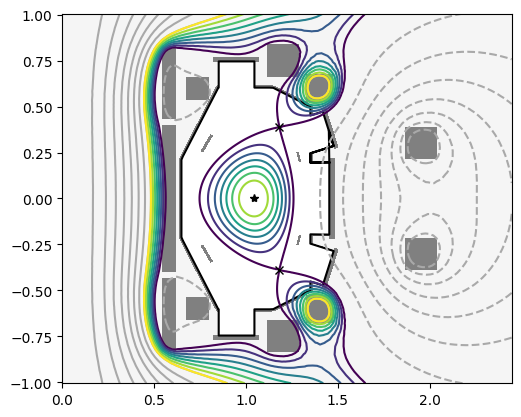

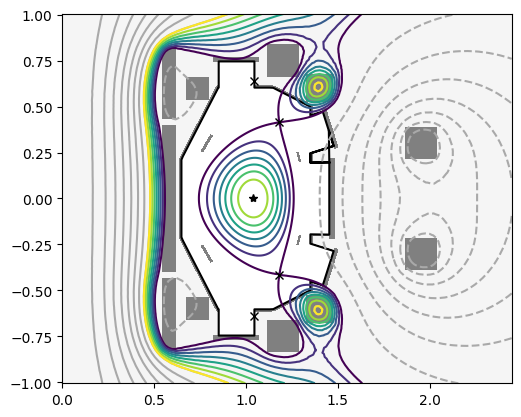

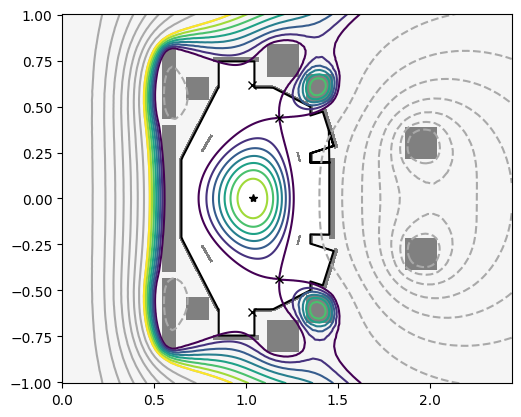

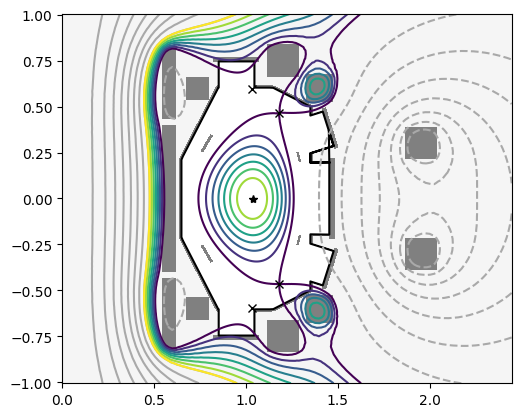

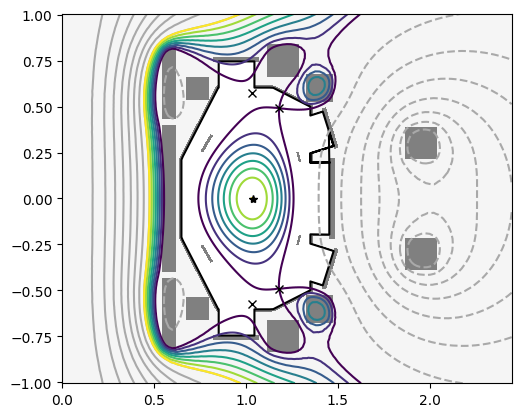

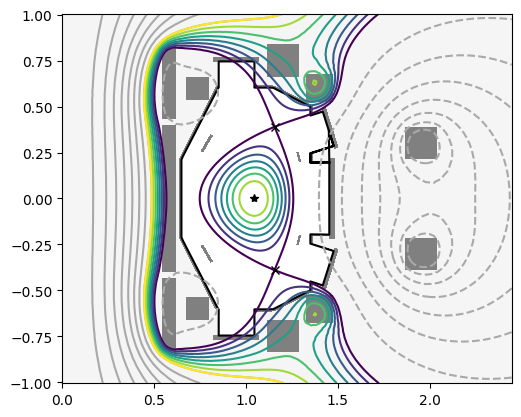

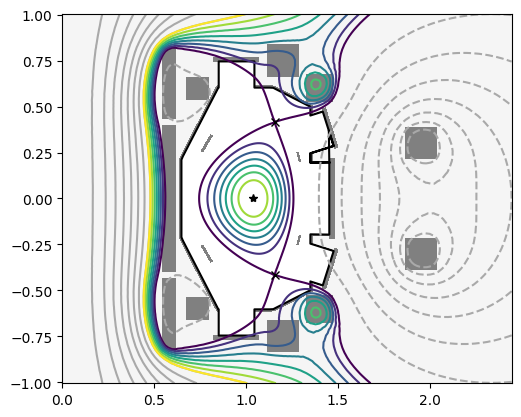

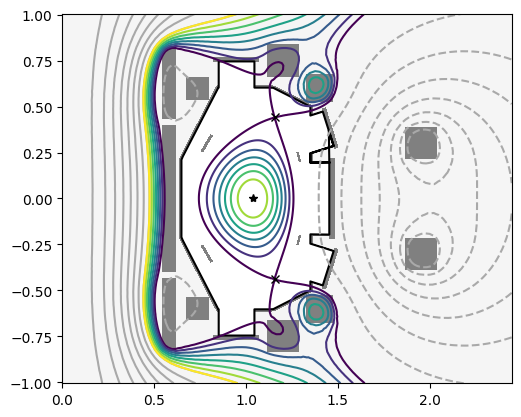

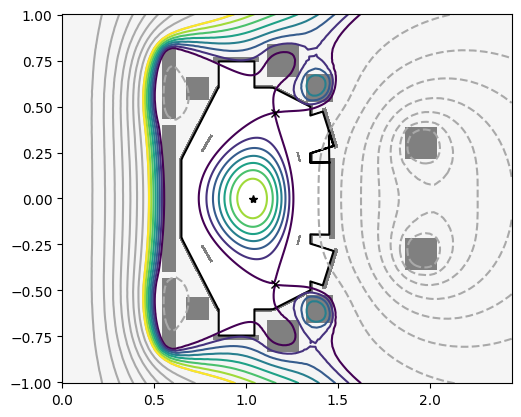

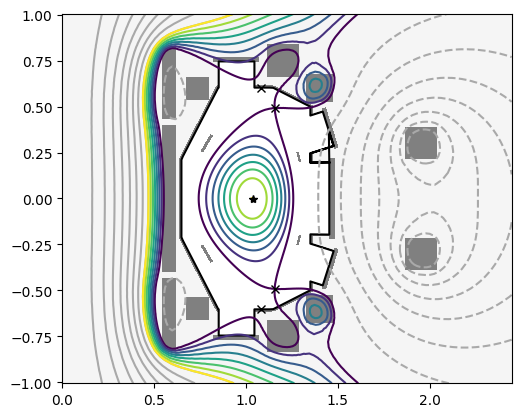

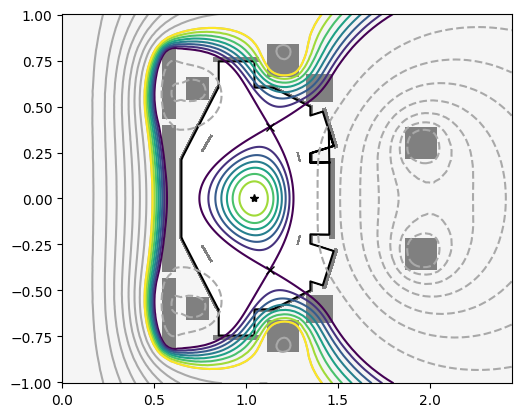

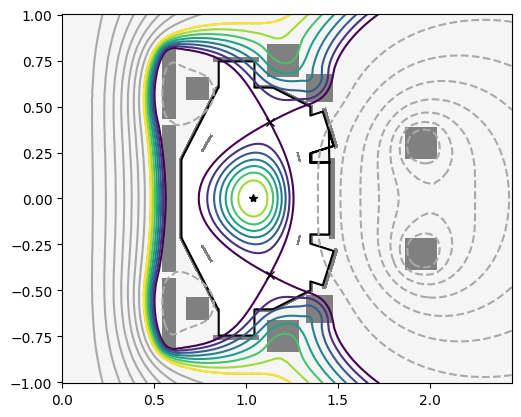

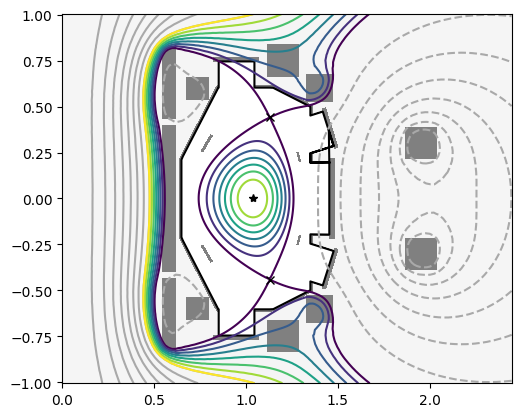

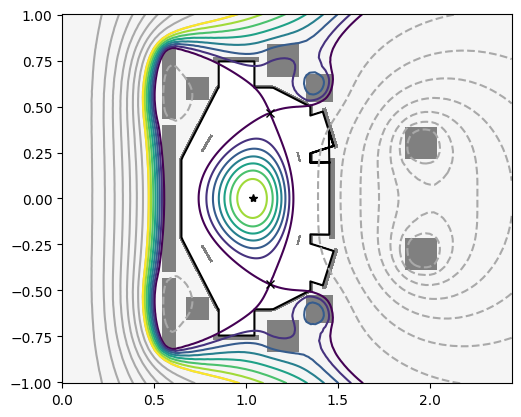

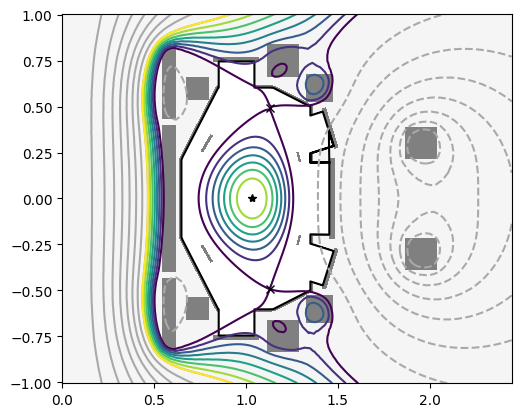

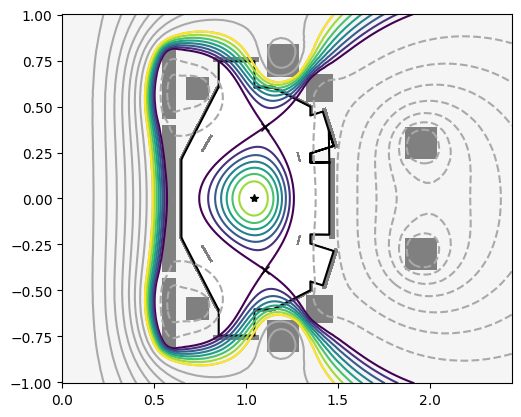

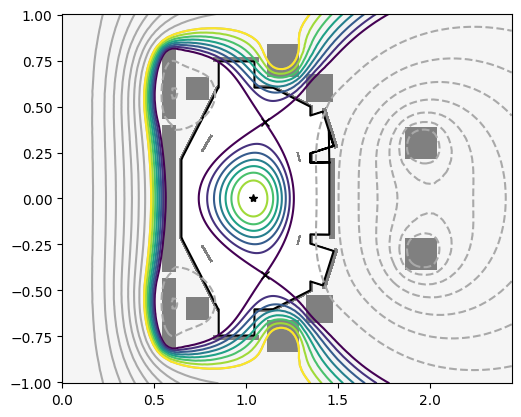

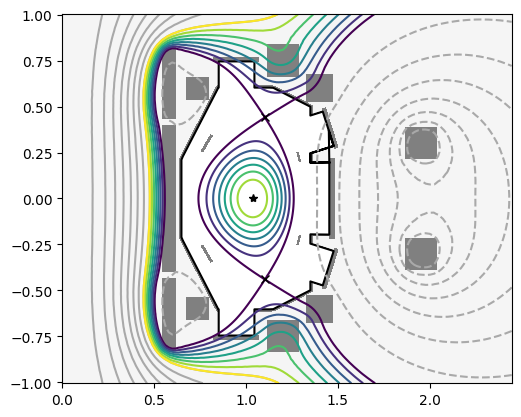

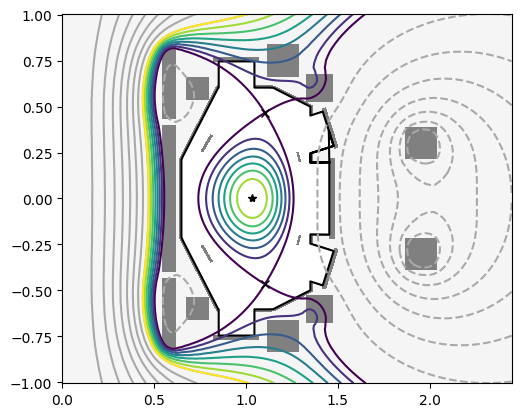

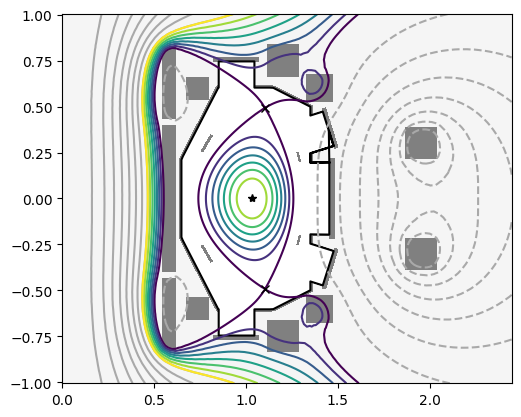

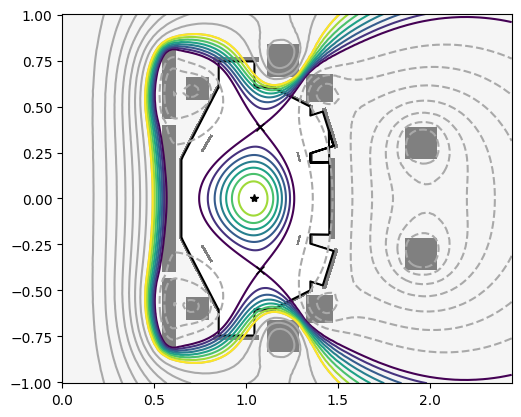

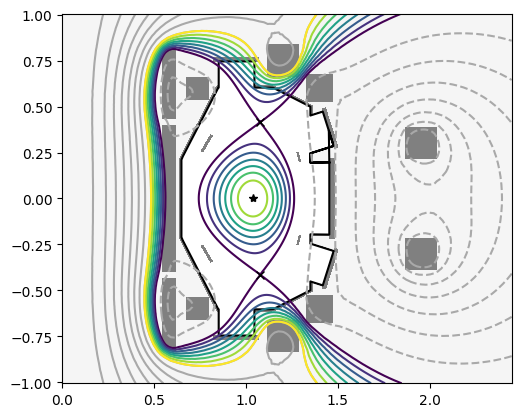

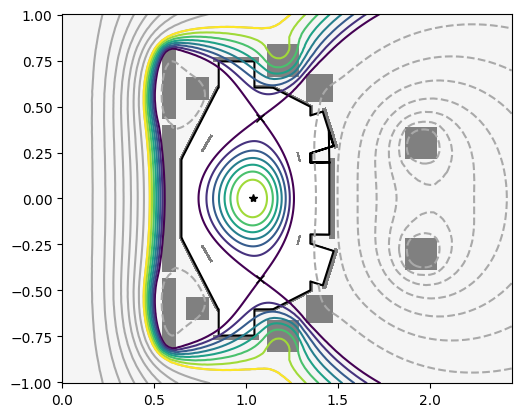

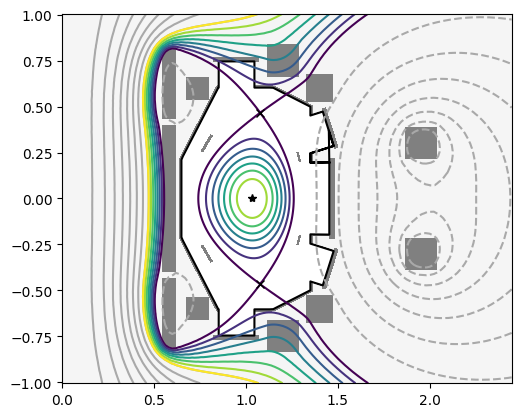

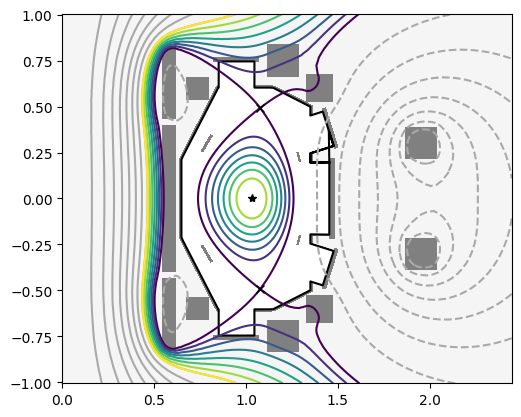

In [3]:
d_s = np.array([-0.7,-0.6, -0.5, -0.4, -0.3])
k_s = np.array([1.5, 1.6, 1.7, 1.8, 1.9])

lcfs = []
q95 = []
d_out = []
k_out = []
for d in d_s:
    for k in k_s:
        mygs = TokaMaker()
        mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
        mygs.setup_regions(cond_dict=cond_dict)
        mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

        coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
        targets = np.zeros(mygs.ncoils+1)
        coil_weights = 0.5*np.ones(mygs.ncoils+1)
        coil_weights[1:3] = 5

        #Set target values for CS coils
        coil_reg_mat[0,0] = 1
        coil_reg_mat[1,1] = 1
        coil_reg_mat[1,0] = -1
        coil_reg_mat[2,2] = 1
        coil_reg_mat[2,1] = -1

        targets[0] = -3E6

    #Enforce up/down symmetry in PF coils
        coil_reg_mat[3,3] = 1
        coil_reg_mat[3,7] = -1
        coil_reg_mat[4,4] = 1
        coil_reg_mat[4,8] = -1
        coil_reg_mat[5,5] = 1
        coil_reg_mat[5,9] = -1
        coil_reg_mat[6,6] = 1
        coil_reg_mat[6,10] = -1
        mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

    #Set upper bound on coil currents
        coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
        coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
        mygs.set_coil_bounds(coil_bounds)

    # Define shape of P' anf FF' profiles
        n_sample = 40
        psi_sample = np.linspace(0.0,1.0,n_sample)
    # Set F*F' profile
        alpha = 2
        gamma = 3
        ffp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
        # Set P' profile
        alpha = 2
        gamma = 3
        pp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

        mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

        # set global targets
        Ip_target = 1E6
        mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)



        # set boundary/saddle point targets
        r, z, zeff = boundaryShape(kapu = k, kapl = k, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True, npts = 8)
        boundary = np.column_stack((r,z))
        boundary = np.nan_to_num(boundary)
        x_points = np.zeros((2,2))
        x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
        x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
        x_weights = 30*np.ones(2)
        mygs.set_saddles(x_points, x_weights)
        isoflux_weights = 30*np.ones(len(boundary))
        mygs.set_isoflux(boundary, isoflux_weights)

        #find equilibrium
        mygs.init_psi(0.68,0,0.2, 1.8,0.3)
        mygs.settings.maxits = 100
        mygs.update_settings()
        mygs.solve()

        fig,ax = plt.subplots()
        mygs.plot_machine(fig,ax)
        mygs.plot_psi(fig,ax)

        mygs.save_eqdsk('temp', lcfs_pad = .001, nr = 600, nz = 600)
        lcfs.append(read_eqdsk('temp')['rzout'])
        
        stats = mygs.get_stats()
        q95.append(stats['q_95'])

        d_out.append(np.min((stats['deltaU'], stats['deltaL'])))
        k_out.append(np.max((stats['kappaU'], stats['kappaL'])))
        mygs.reset()

In [4]:
import json
with open('nsf_geom.json','r') as fid:
    nsf_geom = json.load(fid)

Text(0.94, 0.675, 'PF4')

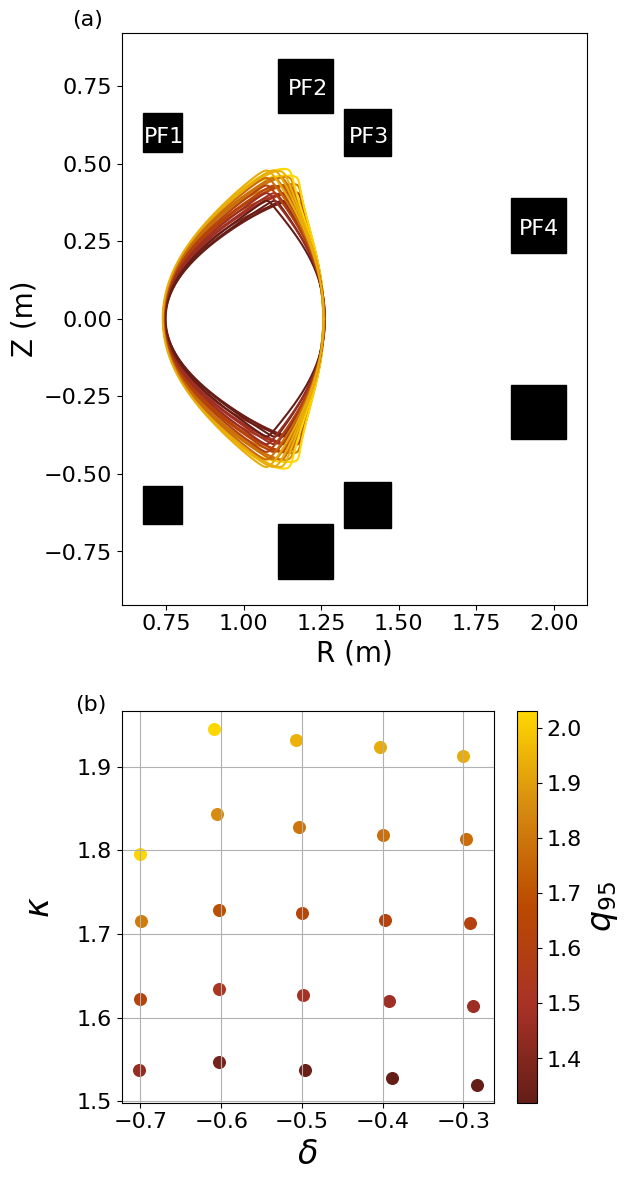

In [64]:
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 1, height_ratios = [1.5,1],  wspace = 0.25)

fig = plt.figure(figsize = (6,14))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.fill(np.array(nsf_geom['PF_1U'])[:,0]/1000, np.array(nsf_geom['PF_1U'])[:,1]/1000, c = 'k')
ax1.fill(np.array(nsf_geom['PF_2U'])[:,0]/1000, np.array(nsf_geom['PF_2U'])[:,1]/1000,  c = 'k')
ax1.fill(np.array(nsf_geom['PF_3U'])[:,0]/1000, np.array(nsf_geom['PF_3U'])[:,1]/1000,  c = 'k')
ax1.fill(np.array(nsf_geom['PF_4U'])[:,0]/1000, np.array(nsf_geom['PF_4U'])[:,1]/1000,  c = 'k')
ax1.fill(np.array(nsf_geom['PF_1L'])[:,0]/1000, np.array(nsf_geom['PF_1L'])[:,1]/1000,  c = 'k')
ax1.fill(np.array(nsf_geom['PF_2L'])[:,0]/1000, np.array(nsf_geom['PF_2L'])[:,1]/1000,  c = 'k')
ax1.fill(np.array(nsf_geom['PF_3L'])[:,0]/1000, np.array(nsf_geom['PF_3L'])[:,1]/1000,  c = 'k')
ax1.fill(np.array(nsf_geom['PF_4L'])[:,0]/1000, np.array(nsf_geom['PF_4L'])[:,1]/1000,  c = 'k')

ax1.set_aspect(aspect = 1)

from matplotlib.colors import LinearSegmentedColormap
#colors = ["rebeccapurple","mediumpurple", "royalblue", "lightseagreen", "mediumaquamarine"]
#nodes = [0., 0.25, 0.5, 0.75,1]
colors = ["#641E16" , "#A93226", "#BA4A00", "#D68910", "gold"]
nodes = [0., 0.25, 0.5, 0.75,  1.0]
#colors = ["#936e69","rosybrown","palevioletred","lightcoral","coral"]
#nodes = [0., 0.2, 0.5, 0.75,  1.0]
cmap1 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
norm = plt.Normalize(np.min(q95), 2.0313886739749916)
c = cmap1(norm(q95))
#colors = ["indigo","mediumpurple","lightsteelblue","slategray","dimgrey"]
#nodes = [0., 0.25, 0.5, 0.75,  1.0]
cmap1 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
norm = plt.Normalize(np.min(q95), 2.0313886739749916)
c = cmap1(norm(q95))
for i in range(25):
    if i != 4:
        ax1.plot(lcfs[i][:,0], lcfs[i][:,1], c = c[i])

for i in range(25):
    if i != 4:
        plt.scatter(d_out[i], k_out[i], color = c[i] , s = 70)

sm = plt.cm.ScalarMappable(cmap=cmap1, norm = norm)
cb = plt.colorbar(sm)
cb.set_label(label=r'$q_{95}$', size = 24)
cb.ax.tick_params(labelsize=16)
ax2.grid()
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax1.set_xlabel('R (m)', fontsize = 20)
ax1.set_ylabel('Z (m)', fontsize = 20)

ax2.set_xlabel(r'$\delta$', fontsize = 24)
ax2.set_ylabel(r'$\kappa$', fontsize = 24, labelpad = 15)

ax1.text(-0.04, 1.04, '(a)', transform=ax1.transAxes,fontsize=16, va='top', ha='right', color ='k')
ax2.text(-0.04, 1.04, '(b)', transform=ax2.transAxes,fontsize=16, va='top', ha='right', color ='k')

ax1.text(0.135, 0.835, 'PF1', transform=ax1.transAxes,fontsize=16, va='top', ha='right', color ='w')
ax1.text(0.445, 0.92, 'PF2', transform=ax1.transAxes,fontsize=16, va='top', ha='right', color ='w')
ax1.text(0.575, 0.835, 'PF3', transform=ax1.transAxes,fontsize=16, va='top', ha='right', color ='w')
ax1.text(0.94, 0.675, 'PF4', transform=ax1.transAxes,fontsize=16, va='top', ha='right', color ='w')


In [6]:
print(q95)

[1.4437701889751648, 1.6209943209334836, 1.8118972527144948, 2.0267636842958376, 2.253342507090163, 1.3693308404820062, 1.5253776050357029, 1.6899999817216302, 1.8614095942807216, 2.0313886739749916, 1.3384038066211472, 1.4888066064194538, 1.6414032067761, 1.7971637879608007, 1.9452807087379211, 1.323454368581421, 1.4704981434844542, 1.6245071708685426, 1.7798428248489262, 1.9300997267541824, 1.3196577225505648, 1.4645773850758477, 1.6168096355340567, 1.7751669763287385, 1.934832747300013]
